In [79]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.manifold import Isomap
from spynal.spikes import density
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/ChaoticConsciousness/')
sys.path.append('/Users/adameisen/Documents/MIT/code/ChaoticConsciousness')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
sys.path.append('/Users/adameisen/Documents/MIT/code/DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

In [154]:
def fhn(t, x, k, a, b, tau, I_ext):
    v, w = x
    dvdt = -k*v - (v**3)/3 - w + I_ext
    dwdt = (1/tau)*(v + a - b*w)
    return np.array([dvdt, dwdt])

In [169]:
b/np.sqrt(tau)

0.2262741699796952

In [196]:
dt = 0.01
t_span = [0, 400]
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)
N = 2
a = 0.7
b = 4
tau = 12.5
I_ext = 0.5
x0 = np.random.randn(2)
lamb_vals = [0.8, 0.6, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1]
iterator = tqdm(total=len(lamb_vals)*(T - 1))
# lamb_vals = [0.8]
# lamb_vals = [1, 2, 3, 5, 8, 9]

def g_dW(x, scale=1):
    return scale

signals = {}
for lamb in lamb_vals:
    k = lamb
    # sol = scipy.integrate.solve_ivp(lambda t, x: fhn(t, x, k=k, a=a, b=b, tau=tau, I_ext=I_ext), t_span=t_span, y0=x0, t_eval=t_eval)
    # signals[lamb] = sol.y.T

    dW = np.sqrt(dt) * np.random.randn(T,N)
    # Initialize the x array
    x = np.zeros((T, N))
    x[0] = x0

    # Simulate the stochastic differential equation
    for i in range(1, T):
        x[i] = x[i-1] + fhn((i - 1)*dt, x[i-1], k, a, b, tau, I_ext) * dt + g_dW(x[i-1], scale=0.05) * dW[i]
        iterator.update(1)

    signals[lamb] = x
iterator.close()

  0%|          | 0/319992 [00:00<?, ?it/s]

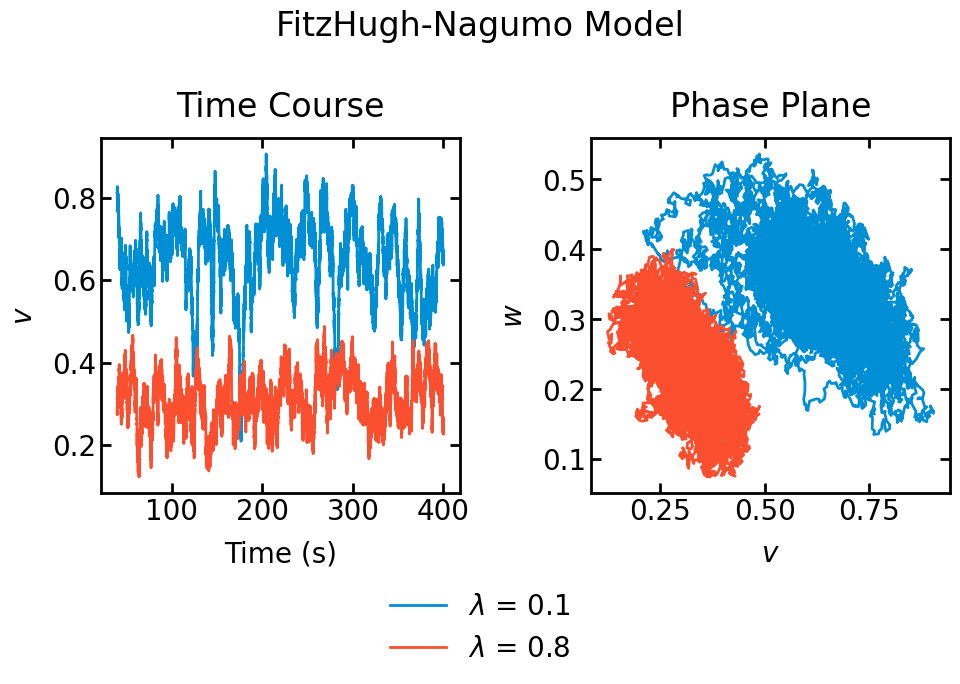

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6 ))
transient = 4000

lns = []
for lamb in [0.1, 0.8]:
    axs[0].plot(t_eval[transient:], signals[lamb][transient:, 0])
    lns += axs[1].plot(signals[lamb][transient:, 0], signals[lamb][transient:, 1], label=fr'$\lambda$ = {lamb}')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('$v$')
axs[0].set_title('Time Course')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$w$')
axs[1].set_title('Phase Plane')
fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.5, -0.05), loc='center')
fig.suptitle('FitzHugh-Nagumo Model')
plt.tight_layout()
plt.show()

# Contraction Analysis

In [199]:
num_indices = 2

parameter_grid=ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]),
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 225, 250, 275, 300, 350, 400]),
)
transient = 4000
window = 10000
T_pred = 4000
device = 'cuda'

N = 2

In [200]:
window = parameter_grid.window_vals[0]
delay_embeds = ['lowpass', 'ordinary']
iterator = tqdm(total=len(delay_embeds)*len(signals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))

results = {}
# for differentiable in [True, False]:
for differentiable in delay_embeds:
    results[differentiable] = {}
    for lamb, x in signals.items():
        np.random.seed(42 + int(1/lamb))
        indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)
        signal = x[transient:transient + window + T_pred, indices]

        AICs = np.zeros((len(parameter_grid.matrix_size_vals), len(parameter_grid.r_vals)))
        contraction_rates = np.zeros(AICs.shape)
        max_eigvals_A = np.zeros(AICs.shape)


        for i, matrix_size in enumerate(parameter_grid.matrix_size_vals):
            if matrix_size >= num_indices:
                if differentiable == 'lowpass':
                    H = signal.copy()
                    n_delays = int(np.ceil(matrix_size/signal.shape[1]))
                    for lag in np.arange(n_delays):
                        RC = dt*lag
                        alpha = dt/(RC + dt)
                        filtered_signal = np.zeros(signal.shape)
                        for t in range(1, signal.shape[0]):
                            filtered_signal[t] = filtered_signal[t-1] + alpha*(signal[t] - filtered_signal[t- 1])
                        H = np.hstack([H, filtered_signal])
                    H_test = H[window:window + T_pred]
                    H = H[:window]
                #     print("Differentiable delay embedding constructed!")
                #     print("Now computing DeLASE")
                #     print("Fitting SVD...")
                    delase = DeLASE(H, n_delays=1, device=device)
                    delase.DMD.compute_hankel()
                    delase.DMD.compute_svd()
                    n = delase.n*delase.n_delays
                #     print("Testing over r...")
                    r_opts = parameter_grid.r_vals

                    for j, r_ in enumerate(r_opts):
                        if r_ <= matrix_size:
                            
                            delase.DMD.compute_havok_dmd(rank=r_)
                            H_pred = delase.DMD.predict(H_test)
                            num_pts = (H_pred.shape[0] - delase.n_delays)*num_indices
                            AIC = float(num_pts*np.log(((H_pred[delase.n_delays:, :num_indices].cpu() - H_test[delase.n_delays:, :num_indices])**2).sum()/num_pts) + 2*(delase.DMD.A_v.shape[0]*delase.DMD.A_v.shape[1] + 1))
                            AICs[i][j] += AIC/num_pts

                            I = torch.eye(n).to(device)
                            A = ((delase.DMD.A_havok_dmd - I)/dt)
                            M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                            eigvals_M = torch.real(torch.linalg.eigvals(M))
                            contraction_rates[i][j] = (1/eigvals_M.max()).cpu().numpy()
                            max_eigvals_A[i][j] = -torch.linalg.eigvals(A).real.max().cpu().numpy()
                        else:
                            AICs[i][j] = np.Inf

                        iterator.update()
                elif differentiable == 'pade':
                    H = signal.copy()
                    n_delays = int(np.ceil(matrix_size/signal.shape[1]))
                    for lag in np.arange(n_delays):
                        tau = dt*lag
                        filtered_signal = np.zeros(signal.shape)
                        for t in range(1, signal.shape[0]):
                            if t == 1:
                                filtered_signal[t] = (tau/(tau + dt))*filtered_signal[t-1] + ((dt - 1)/(tau + dt))*signal[t]
                            else:
                                filtered_signal[t] = (tau/(tau + dt))*filtered_signal[t-1] + ((dt - 1)/(tau + dt))*signal[t] + (1/(tau + dt))*signal[t-1]
                        H = np.hstack([H, filtered_signal])
                    H_test = H[window:window + T_pred]
                    H = H[:window]
                #     print("Differentiable delay embedding constructed!")
                #     print("Now computing DeLASE")
                #     print("Fitting SVD...")
                    delase = DeLASE(H, n_delays=1, device=device)
                    delase.DMD.compute_hankel()
                    delase.DMD.compute_svd()
                    n = delase.n*delase.n_delays
                #     print("Testing over r...")
                    r_opts = parameter_grid.r_vals

                    for j, r_ in enumerate(r_opts):
                        if r_ <= matrix_size:
                            
                            delase.DMD.compute_havok_dmd(rank=r_)
                            H_pred = delase.DMD.predict(H_test)
                            num_pts = (H_pred.shape[0] - delase.n_delays)*num_indices
                            AIC = float(num_pts*np.log(((H_pred[delase.n_delays:, :num_indices].cpu() - H_test[delase.n_delays:, :num_indices])**2).sum()/num_pts) + 2*(delase.DMD.A_v.shape[0]*delase.DMD.A_v.shape[1] + 1))
                            AICs[i][j] += AIC/num_pts

                            I = torch.eye(n).to(device)
                            A = ((delase.DMD.A_havok_dmd - I)/dt)
                            M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                            eigvals_M = torch.real(torch.linalg.eigvals(M))
                            contraction_rates[i][j] = (1/eigvals_M.max()).cpu().numpy()
                            max_eigvals_A[i][j] = -torch.linalg.eigvals(A).real.max().cpu().numpy()
                        else:
                            AICs[i][j] = np.Inf

                        iterator.update()
                        
                else:

                    delase = DeLASE(signal, matrix_size=matrix_size, device=device)
                    delase.DMD.compute_hankel()
                    delase.DMD.compute_svd()
                    n = delase.n*delase.n_delays
                    #     print("Testing over r...")
                    r_opts = parameter_grid.r_vals

                    signal_test = signal[window:window + T_pred]

                    for j, r_ in enumerate(r_opts):
                        if r_ <= matrix_size:
                            delase.DMD.compute_havok_dmd(rank=r_)
                            signal_pred = delase.DMD.predict(signal_test)
                            num_pts = (signal_pred.shape[0] - delase.n_delays)*num_indices
                            AIC = float(num_pts*np.log(((signal_pred[delase.n_delays:, :num_indices].cpu() - signal_test[delase.n_delays:, :num_indices])**2).sum()/num_pts) + 2*(delase.DMD.A_v.shape[0]*delase.DMD.A_v.shape[1] + 1))
                            AICs[i][j] += AIC/num_pts

                            I = torch.eye(n).to(device)
                            A = ((delase.DMD.A_havok_dmd - I)/dt)
                            M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                            eigvals_M = torch.real(torch.linalg.eigvals(M))
                            contraction_rates[i][j] = (1/eigvals_M.max()).cpu().numpy()
                            max_eigvals_A[i][j] = -torch.linalg.eigvals(A).real.max().cpu().numpy()
                        else:
                            AICs[i][j] = np.Inf

                        iterator.update()
            else:
                iterator.update(len(parameter_grid.r_vals))


            m_index, r_index = np.unravel_index(AICs.argmin(), shape=AICs.shape)

            results[differentiable][lamb] = dict(
                AICs=AICs,
                contraction_rates=contraction_rates,
                max_eigvals_A=max_eigvals_A,
                m_index=m_index,
                r_index=r_index

            )

        

iterator.close()
    

  0%|          | 0/3072 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/dynamical-trajectories/lib/python3.9/site-packages/scipy/linalg/_solvers.py:191: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  warnings.warn('Input "a" has an eigenvalue pair whose sum is '


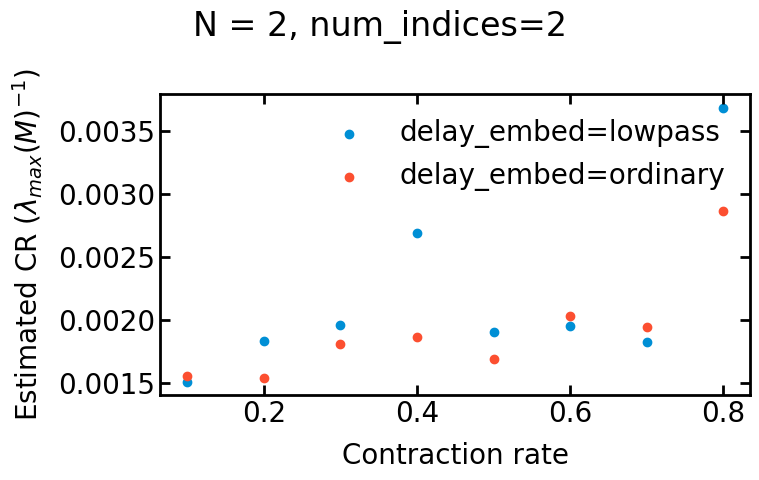

In [202]:
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
for differentiable in delay_embeds:
    plt.scatter([lamb for lamb in results[differentiable].keys()], [ret['contraction_rates'][ret['m_index'], ret['r_index']] for ret in results[differentiable].values()], label=f"delay_embed={differentiable}")
    # plt.xscale('log')
    plt.xlabel('Contraction rate')
    plt.ylabel(r'Estimated CR ($\lambda_{max}(M)^{-1}$)')

    # plt.subplot(1, 2, 2)
    # plt.scatter([lamb for lamb in results.keys()], [ret['max_eigvals_A'][ret['m_index'], ret['r_index']] for ret in results.values()])
    # # plt.xscale('log')
    # plt.xlabel('Contraction rate')
    # plt.ylabel(r'Estimated CR ($\lambda_{max}(A)$)')
# plt.plot([lamb for lamb in results[differentiable].keys()], [lamb for lamb in results[differentiable].keys()], linestyle='--', c='k')
plt.suptitle(f'N = {N}, num_indices={num_indices}')
plt.legend()
plt.tight_layout()
plt.show()

In [204]:
pd.to_pickle(results, "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/contraction_testing/fhn.pkl")

In [206]:
pd.to_pickle(signals, "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/contraction_testing/fhn_signals.pkl")